In [30]:
import json

with open("san_francisco_censustracts.json") as jsondata:
    d = json.load(jsondata)
    for feature in d["features"]:
        if feature["properties"]["DISPLAY_NAME"] == "100 Campus Drive, Stanford":
            stanford_nodes = feature["geometry"]["coordinates"]
        if feature["properties"]["DISPLAY_NAME"] == "700 Meder Street, Santa Cruz":
            ucsc_nodes = feature["geometry"]["coordinates"]

In [31]:
print(stanford_nodes)

[[[[-122.191325, 37.425302], [-122.18961, 37.427137], [-122.189803, 37.428187], [-122.189879, 37.42883], [-122.182288, 37.434498], [-122.17811, 37.43344], [-122.17812, 37.43172], [-122.17497, 37.4308], [-122.172679, 37.436281], [-122.17244, 37.43675], [-122.17054, 37.4409], [-122.17043, 37.44111], [-122.17018, 37.4414], [-122.16941, 37.44203], [-122.168872, 37.442504], [-122.16763, 37.44363], [-122.165424, 37.441929], [-122.165712, 37.44125], [-122.16893, 37.43145], [-122.17032, 37.429086], [-122.171583, 37.429351], [-122.17373, 37.42636], [-122.17305, 37.42519], [-122.17315, 37.42275], [-122.16905, 37.42252], [-122.16836, 37.4214], [-122.17074, 37.41952], [-122.17287, 37.41908], [-122.17533, 37.41937], [-122.17687, 37.42033], [-122.17722, 37.42046], [-122.17732, 37.42051], [-122.18224, 37.42192], [-122.18501, 37.42203], [-122.19084, 37.424365], [-122.191325, 37.425302]]]]


In [32]:
from scipy.spatial import Delaunay
import numpy as np

In [33]:
stanford_nodes = stanford_nodes[0][0]
ucsc_nodes = ucsc_nodes[0][0]

nodes = []
for node in stanford_nodes:
    nodes.append(node)
for node in ucsc_nodes:
    nodes.append(node)
points = np.array(nodes)

In [85]:
print(points)

[[-122.191325   37.425302]
 [-122.18961    37.427137]
 [-122.189803   37.428187]
 [-122.189879   37.42883 ]
 [-122.182288   37.434498]
 [-122.17811    37.43344 ]
 [-122.17812    37.43172 ]
 [-122.17497    37.4308  ]
 [-122.172679   37.436281]
 [-122.17244    37.43675 ]
 [-122.17054    37.4409  ]
 [-122.17043    37.44111 ]
 [-122.17018    37.4414  ]
 [-122.16941    37.44203 ]
 [-122.168872   37.442504]
 [-122.16763    37.44363 ]
 [-122.165424   37.441929]
 [-122.165712   37.44125 ]
 [-122.16893    37.43145 ]
 [-122.17032    37.429086]
 [-122.171583   37.429351]
 [-122.17373    37.42636 ]
 [-122.17305    37.42519 ]
 [-122.17315    37.42275 ]
 [-122.16905    37.42252 ]
 [-122.16836    37.4214  ]
 [-122.17074    37.41952 ]
 [-122.17287    37.41908 ]
 [-122.17533    37.41937 ]
 [-122.17687    37.42033 ]
 [-122.17722    37.42046 ]
 [-122.17732    37.42051 ]
 [-122.18224    37.42192 ]
 [-122.18501    37.42203 ]
 [-122.19084    37.424365]
 [-122.191325   37.425302]
 [-122.084299   36.962692]
 

In [35]:
tri = Delaunay(points)

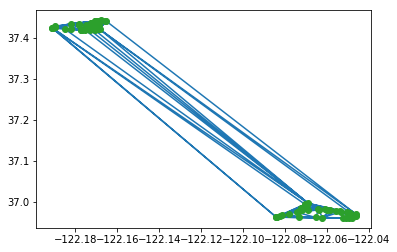

In [37]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [80]:
edges = set() 
for n in range(tri.nsimplex): 
    edge = sorted([tri.vertices[n,0], tri.vertices[n,1]]) 
    edges.add((edge[0], edge[1])) 
    edge = sorted([tri.vertices[n,0], tri.vertices[n,2]]) 
    edges.add((edge[0], edge[1])) 
    edge = sorted([tri.vertices[n,1], tri.vertices[n,2]]) 
    edges.add((edge[0], edge[1])) 
print(edges)

{(26, 47), (1, 34), (47, 54), (14, 17), (54, 55), (62, 64), (10, 17), (39, 70), (40, 41), (13, 17), (1, 6), (17, 25), (18, 19), (23, 26), (34, 46), (5, 8), (6, 7), (46, 48), (44, 45), (52, 53), (47, 53), (45, 48), (25, 26), (49, 53), (58, 63), (21, 31), (12, 17), (16, 25), (63, 67), (27, 28), (34, 36), (25, 60), (18, 20), (4, 10), (29, 30), (37, 38), (4, 5), (56, 58), (19, 24), (44, 50), (57, 59), (14, 15), (28, 32), (55, 56), (0, 1), (33, 34), (17, 18), (66, 71), (18, 25), (23, 28), (4, 15), (61, 63), (51, 68), (8, 18), (15, 16), (67, 68), (7, 8), (7, 21), (22, 23), (30, 32), (69, 70), (36, 46), (8, 9), (40, 51), (4, 12), (43, 46), (25, 47), (0, 36), (51, 54), (40, 70), (41, 50), (1, 33), (57, 60), (47, 49), (65, 66), (44, 52), (58, 59), (20, 21), (12, 13), (6, 32), (41, 43), (34, 47), (43, 45), (51, 53), (37, 71), (7, 18), (28, 47), (50, 51), (66, 67), (63, 66), (23, 24), (4, 11), (38, 39), (4, 6), (5, 7), (24, 25), (57, 58), (28, 33), (59, 60), (0, 2), (50, 52), (63, 65), (68, 71), 

In [56]:
import networkx as nx 
graph = nx.Graph(list(edges)) 
# print(graph.edges()) 

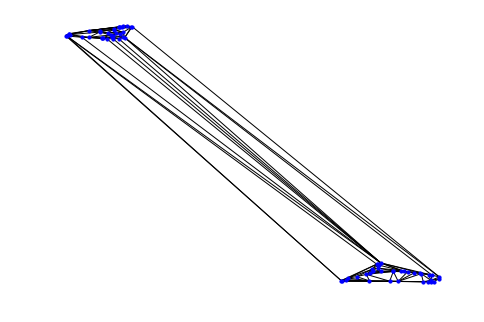

In [76]:
import matplotlib.pyplot as plt 
pointIDXY = dict(zip(range(len(points)), points)) 
nx.draw(graph, pointIDXY,node_size = 10, node_color = "blue") 
plt.show() 

In [82]:
print(len(edges))

198


In [91]:
# Q12
# • Each degree of latitude and longitude ≈ 69 miles
# • Carlength≈5m=0.003mile
# • Cars maintain a safety distance of 2 seconds to the next car
# • Each road has 2 lanes in each direction
# Multi-lane highway driving	110 kph	66 mph
speed = 66
for i in range(len(edges)):
    edge = list(edges)[i]
    start = points[edge[0]]
    end = points[edge[1]]
    road_len = np.sqrt(np.power(end[1] - end[0], 2) + np.power(start[1] - start[0], 2)) * 69.0
    traffic_flow = (road_len / (0.003 + (60 * 2)/3600.0))
    print("For road: ", i, " the traffic flow is: ", traffic_flow)
    

For road:  0  the traffic flow is:  427908.0029504536
For road:  1  the traffic flow is:  428681.9555310379
For road:  2  the traffic flow is:  427169.33630000125
For road:  3  the traffic flow is:  428663.6739504498
For road:  4  the traffic flow is:  427132.84838174947
For road:  5  the traffic flow is:  427056.5836682545
For road:  6  the traffic flow is:  428663.7598943132
For road:  7  the traffic flow is:  427140.2277062333
For road:  8  the traffic flow is:  427160.64679097896
For road:  9  the traffic flow is:  428663.7598943132
For road:  10  the traffic flow is:  428674.75121379644
For road:  11  the traffic flow is:  428634.6473963354
For road:  12  the traffic flow is:  428638.7612810434
For road:  13  the traffic flow is:  428620.46361514396
For road:  14  the traffic flow is:  427940.5488543273
For road:  15  the traffic flow is:  428666.5906028196
For road:  16  the traffic flow is:  428660.01063815644
For road:  17  the traffic flow is:  427198.58242047025
For road:  18